# 2.2 The Split-Apply-Combine Strategy

In [1]:
%matplotlib inline
import pandas as pd

In the previous section, we discussed how to restrict our analysis to a particular subset of observations using boolean masks. So, for example, if we wanted to calculate the survival rate for passengers in third class, we would write:

In [2]:
titanic_df = pd.read_csv("titanic.csv")
titanic_df[titanic_df.pclass == 3].survived.mean()

0.2552891396332863

But what if we wanted to calculate the survival rate by class? We could slice the data set three times, once for each class:

In [3]:
(titanic_df[titanic_df.pclass == 1].survived.mean(), 
 titanic_df[titanic_df.pclass == 2].survived.mean(), 
 titanic_df[titanic_df.pclass == 3].survived.mean())

(0.6191950464396285, 0.4296028880866426, 0.2552891396332863)

But this code is inefficient and repetitive. It also does not generalize well to variables with hundreds of possible categories. 

The problem of calculating the survival rate by class is an example of a problem that can be solved using the **split-apply-combine strategy**. The key insight here is that many data analyses follow the same basic pattern:

- First, a data set is **split** into several subsets based on some variable.
- Next, some analysis is **applied** to each subset.
- Finally, the results from each analysis are **combined**.

The three steps are diagrammed in the figure below:

![](split_apply_combine.png) [source](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.08-Aggregation-and-Grouping.ipynb)

Applying this strategy to our working example above, we should first _split_ up the Titanic data according to the value of `pclass`, _apply_ `.survived.mean()` to each subset, and finally _combine_ the results into one `Series`.

[_Note:_ The term "split-apply-combine" was coined by Hadley Wickham in [a 2011 paper](https://www.jstatsoft.org/article/view/v040i01), but the idea is not new. It should already be familiar to you if you know SQL or MapReduce.]

## Split-Apply-Combine in `pandas`: the `.groupby()` method

To implement the split-apply-combine strategy in `pandas`, we use the `.groupby()` method. First, we specify one or more variables to split on in the argument to `.groupby()`. Then, we specify our analysis as usual. Pandas will handle splitting the data, applying the analysis to each subset, and combining the results at the end.

In [4]:
titanic_df.groupby("pclass").survived.mean()

pclass
1    0.619195
2    0.429603
3    0.255289
Name: survived, dtype: float64

In [5]:
titanic_df.survived.mean()

0.3819709702062643

Compare this line of code with the code to calculate the overall survival rate:

`titanic_df.survived.mean()`.

The only difference is `.groupby("pclass")`. This turns a `DataFrame` into a `DataFrameGroupBy` object, which behaves like a `DataFrame`, except that any analysis that we specify will be applied to subsets of the `DataFrame` instead of the whole `DataFrame`.

You can even make visualizations with `.groupby()`! To plot the age distribution of the survivors and non-survivors, we can group by the `survived` variable and then ask for a histogram of `age`. Behind the scenes, `pandas` will do this once for the survivors and again for the non-survivors and then combine them into one histogram.

survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

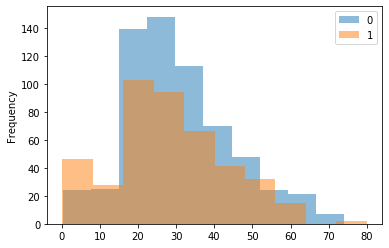

In [6]:
titanic_df.groupby("survived").age.plot.hist(alpha=.5, legend=True)

It is also possible to group by more than one variable. Simply pass in a list of variable names to `.groupby()`. For example, the following code calculates the survival rate by class and sex:

In [7]:
survival_rates = titanic_df.groupby(["pclass", "sex"])["survived"].mean()
survival_rates

pclass  sex   
1       female    0.965278
        male      0.340782
2       female    0.886792
        male      0.146199
3       female    0.490741
        male      0.152130
Name: survived, dtype: float64

It's clear that survival rates on the Titanic varied drastically by class and by sex.

Notice that when we use `.groupby()`, the resulting index is whatever variable(s) we grouped by. Since we grouped by two variables, this index actually has two levels. An index with more than one level is called a `MultiIndex` in `pandas`. To access a particular row in a `DataFrame` that is indexed by a `MultiIndex`, we pass in a tuple of the values we want from each level.

So, for example, to get female passengers in 2nd class, we would do:

In [8]:
survival_rates.loc[(2, "female")]

0.8867924528301887

If we pass in fewer values than there are levels in the index, `pandas` will return everything from the remaining levels.

In [9]:
survival_rates.loc[2]

sex
female    0.886792
male      0.146199
Name: survived, dtype: float64

# Exercises

Exercises 1-5 work with the Tips data set (`tips.csv`). The following code reads in the data into a `DataFrame` called `tips_df` and creates a new column called `tip_percent` out of the `tip` and `total_bill` columns. This new column represents the percentage tip paid (as a number between 0 and 1).

In [10]:
tips_df = pd.read_csv("tips.csv")
tips_df["tip_percent"] = tips_df.tip / tips_df.totbill
tips_df

,obs,totbill,tip,sex,smoker,day,time,size,tip_percent
0,1,16.99,1.01,F,No,Sun,Night,2,0.059447
1,2,10.34,1.66,M,No,Sun,Night,3,0.160542
2,3,21.01,3.50,M,No,Sun,Night,3,0.166587
3,4,23.68,3.31,M,No,Sun,Night,2,0.139780
4,5,24.59,3.61,F,No,Sun,Night,4,0.146808
...,...,...,...,...,...,...,...,...,...
239,240,29.03,5.92,M,No,Sat,Night,3,0.203927
240,241,27.18,2.00,F,Yes,Sat,Night,2,0.073584
241,242,22.67,2.00,M,Yes,Sat,Night,2,0.088222
242,243,17.82,1.75,M,No,Sat,Night,2,0.098204


**Exercise 1.** On which day of the week does the waiter serve the largest parties, on average? (You did this exercise in the previous section. See how much easier it is to do using `.groupby()`.)

In [11]:
# YOUR CODE HERE
tips_df.groupby('day')['size'].mean()

day
Fri    2.105263
Sat    2.517241
Sun    2.842105
Thu    2.451613
Name: size, dtype: float64

**Exercise 2.** Calculate the average bill by day and time. What day-time combination has the highest average bill?

In [12]:
# YOUR CODE HERE
bill_time = tips_df.groupby(['day', 'time'])['totbill'].mean()
bill_time

day  time 
Fri  Day      12.845714
     Night    19.663333
Sat  Night    20.441379
Sun  Night    21.410000
Thu  Day      17.664754
     Night    18.780000
Name: totbill, dtype: float64

**Exercise 3.** Extract the average bill for Friday lunch from the result of Exercise 2.

In [13]:
# YOUR CODE HERE
bill_time.loc[('Fri', 'Day')]

12.845714285714285

**Exercise 4.** Use `.groupby()` to make a visualization comparing the distribution of tip percentages left by males and females. How do they compare?

sex
F    AxesSubplot(0.125,0.125;0.775x0.755)
M    AxesSubplot(0.125,0.125;0.775x0.755)
Name: tip_percent, dtype: object

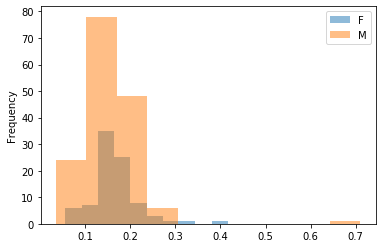

In [14]:
# YOUR CODE HERE
tips_df.groupby('sex')['tip_percent'].plot.hist(alpha = .5, legend = True)

**Exercise 5.** Make a visualization that shows the average tip percentage as a function of table size.

In [15]:
# YOUR CODE HERE
tips_df.groupby('size')['tip_percent'].mean()

size
1    0.217292
2    0.165719
3    0.152157
4    0.145949
5    0.141495
6    0.156229
Name: tip_percent, dtype: float64

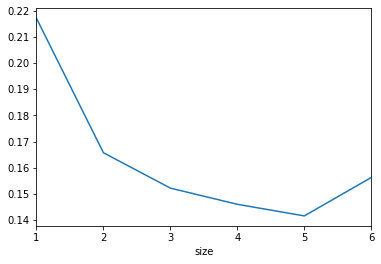

In [16]:
tips_df.groupby('size')['tip_percent'].mean().plot(x = 'size')

import vs %
histogram 2 data side by side